In [40]:
reset -fs

In [41]:
import re
import json
import pprint
import operator
import itertools
import numpy as np
import pandas as pd
import seaborn as sns
import datalab.bigquery as bq
import matplotlib.pyplot as plt
sns.set_style('white')
%matplotlib inline

In [42]:
pd.set_option('display.max_colwidth', -1)

In [ ]:
pd.options.display.float_format = '{:.2f}'.format

In [43]:
%bigquery schema --table firebase-wellio:recipes.imported_recipes

In [93]:
%%sql --module derived_nutrition_versions
SELECT
INTEGER(RIGHT(derived_nutrition_version, LENGTH(derived_nutrition_version)-1)) AS nutrition_version
FROM [firebase-wellio:recipes.imported_recipes]
GROUP BY nutrition_version
ORDER BY nutrition_version DESC

In [94]:
%%bigquery execute -q derived_nutrition_versions

nutrition_version
10
9
8
7
6
5
2
""


In [147]:
%%sql --module epicurious_calories_derived_nutrition
SELECT url, derived_nutrition AS calories
FROM [firebase-wellio:recipes.imported_recipes]
WHERE url LIKE '%epicurious.com%' AND derived_nutrition IS NOT NULL AND INTEGER(RIGHT(derived_nutrition_version, 
  LENGTH(derived_nutrition_version)-1)) = 10 AND derived_nutrition LIKE '%"unit": "kcal"%'

In [148]:
%%bigquery execute -q epicurious_calories_derived_nutrition

url,calories
http://www.epicurious.com/recipes/member/views/spinach-and-cheese-roll-ups-1246962,"{""name"": ""Energy"", ""nutrient_id"": ""208"", ""unit"": ""kcal"", ""agg_value"": 1616.617937582621}"
http://www.epicurious.com/recipes/member/views/parmesan-corn-chowder-1253165,"{""name"": ""Energy"", ""nutrient_id"": ""208"", ""unit"": ""kcal"", ""agg_value"": 2411.5844127350238}"
http://www.epicurious.com/recipes/member/views/-grilled-pecan-pork-loin-with-bourbon-onion-glaze-1204490,"{""name"": ""Energy"", ""nutrient_id"": ""208"", ""unit"": ""kcal"", ""agg_value"": 5216.15205532213}"
http://www.epicurious.com/recipes/member/views/pork-loin-kebab-1220262,"{""name"": ""Energy"", ""nutrient_id"": ""208"", ""unit"": ""kcal"", ""agg_value"": 1212.1584456196588}"
http://www.epicurious.com/recipes/member/views/apple-pie-dressing-50167941,"{""name"": ""Energy"", ""nutrient_id"": ""208"", ""unit"": ""kcal"", ""agg_value"": 158.90949860189306}"
http://www.epicurious.com/recipes/member/views/zuccotto-1249563,"{""name"": ""Energy"", ""nutrient_id"": ""208"", ""unit"": ""kcal"", ""agg_value"": 4391.360493939357}"
http://www.epicurious.com/recipes/member/views/breaded-chicken-baked-1218127,"{""name"": ""Energy"", ""nutrient_id"": ""208"", ""unit"": ""kcal"", ""agg_value"": 160.93957007843437}"
http://www.epicurious.com/recipes/member/views/chocolate-pretzel-rods-50078522,"{""name"": ""Energy"", ""nutrient_id"": ""208"", ""unit"": ""kcal"", ""agg_value"": 2896.869757221271}"
http://www.epicurious.com/recipes/member/views/white-beans-w-dried-tomatoes-prosciutto-and-sage-1206088,"{""name"": ""Energy"", ""nutrient_id"": ""208"", ""unit"": ""kcal"", ""agg_value"": 7054.235031907789}"
http://www.epicurious.com/recipes/member/views/moms-korean-whole-fish-1200987,"{""name"": ""Energy"", ""nutrient_id"": ""208"", ""unit"": ""kcal"", ""agg_value"": 343.7844734495024}"


### Export

In [149]:
# epicurious_derived_calories_df = bq.Query(epicurious_calories_derived_nutrition).to_dataframe(max_rows=1000)
epicurious_derived_calories_df = bq.Query(epicurious_calories_derived_nutrition).to_dataframe()

In [268]:
%%sql --module epicurious_calories_nutrition
SELECT url, nutrition AS calories, FLOAT(RIGHT(nutrition, LENGTH(nutrition) - LENGTH('Calories'))) AS calories_amount
FROM FLATTEN([firebase-wellio:recipes.imported_recipes], nutrition)
WHERE url LIKE '%epicurious.com%' AND derived_nutrition IS NOT NULL AND INTEGER(RIGHT(derived_nutrition_version, 
  LENGTH(derived_nutrition_version)-1)) = 10 AND nutrition LIKE 'Calories%'
  AND nutrition NOT LIKE 'Calories from%'

In [269]:
%%bigquery execute -q epicurious_calories_nutrition

url,calories,calories_amount
http://www.epicurious.com/recipes/food/views/3-ingredient-roasted-carrots-with-pistachio-pesto,Calories 496,496.0
http://www.epicurious.com/recipes/food/views/fettuccine-meatball-lasagne-236984,Calories 961,961.0
http://www.epicurious.com/recipes/food/views/mashed-yam-and-plantain,Calories 166,166.0
http://www.epicurious.com/recipes/member/views/nz-leek-potato-soup-50035786,Calories 273,273.0
http://www.epicurious.com/recipes/food/views/grilled-eggplant-stacks-with-tomato-and-feta-232478,Calories 247,247.0
http://www.epicurious.com/recipes/member/views/italian-baked-eggs-52558781,Calories 334,334.0
http://www.epicurious.com/recipes/member/views/mushroom-chevre-tarts-1208380,Calories 123,123.0
http://www.epicurious.com/recipes/member/views/nz-leek-potato-soup-50035786,Calories 273,273.0
http://www.epicurious.com/recipes/food/views/gorgonzola-chicken-breasts-350591,Calories 514,514.0
http://www.epicurious.com/recipes/member/views/nz-leek-potato-soup-50035786,Calories 273,273.0


In [295]:
epicurious_calories_df = bq.Query(epicurious_calories_nutrition).to_dataframe()

### Sampling:
https://www.oreilly.com/learning/repeatable-sampling-of-data-sets-in-bigquery-for-machine-learning

In [254]:
#epicurious_calories_df['calories_amount'] = epicurious_calories_df['calories']

In [296]:
epicurious_calories_df.head()

,url,calories,calories_amount
0,http://www.epicurious.com/recipes/member/views/broccoli-and-cheddar-soup-52651071,Calories 394,394.00
1,http://www.epicurious.com/recipes/food/views/3-ingredient-roasted-carrots-with-pistachio-pesto,Calories 496,496.00
2,http://www.epicurious.com/recipes/member/views/grilled-spicy-lime-chicken-with-black-bean-and-avocado-salad-1205592,Calories 1033,1033.00
3,http://www.epicurious.com/recipes/food/views/fettuccine-meatball-lasagne-236984,Calories 961,961.00
4,http://www.epicurious.com/recipes/food/views/mashed-yam-and-plantain,Calories 166,166.00


In [234]:
#epicurious_calories_df.calories_amount.replace('Calories', '', regex=True, inplace=True)

In [297]:
epicurious_calories_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 314548 entries, 0 to 314547
Data columns (total 3 columns):
url                314548 non-null object
calories           314548 non-null object
calories_amount    314548 non-null float64
dtypes: float64(1), object(2)
memory usage: 7.2+ MB


In [236]:
#epicurious_calories_df.calories_amount = pd.to_numeric(epicurious_calories_df.calories_amount)

In [298]:
epicurious_calories_df.calories_amount.describe()

count   314548.00  
mean    1620.59    
std     191429.13  
min     0.00       
25%     256.00     
50%     393.00     
75%     694.00     
max     44659793.00
Name: calories_amount, dtype: float64

In [230]:
#epicurious_calories_df['calories_amount'] = epicurious_calories_df['calories_amount'].apply(lambda x: '{:.2f}'.format(x))

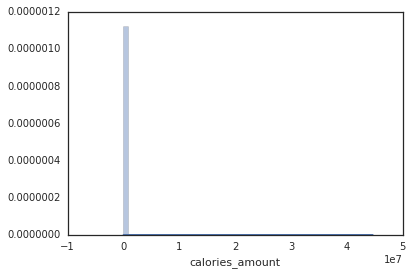

In [299]:
sns.distplot(epicurious_calories_df['calories_amount']);

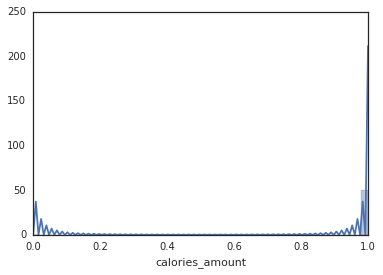

In [300]:
sns.distplot(epicurious_calories_df['calories_amount'] > 0);